In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import h5py
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


In [71]:
class RedNeuronalGeneral(nn.Module):
    def __init__(self, input_shape, num_classes=3):
        super(RedNeuronalGeneral, self).__init__()
        
        # 1. Calculamos dinámicamente el tamaño aplanado (Flatten)
        self.input_dim = np.prod(input_shape)
        
        print(f"Inicializando red para entrada {input_shape} -> {self.input_dim} neuronas de entrada.")

        # 2. Definimos la arquitectura Flatten + MLP
        #       Flatten -> Dense -> Dense -> Out
        
        self.flatten = nn.Flatten()
        
        self.layers = nn.Sequential(
            # Bloque Denso 1 
            nn.Linear(self.input_dim, 256), # De n entradas a 256 neuronas
            nn.BatchNorm1d(256), # Batch Normalization
            nn.LeakyReLU(0.1), # Activación LeakyReLU alpha=0.1
            nn.Dropout(0.3), # Dropout 30%
            
            # Bloque Denso 2
            nn.Linear(256, 128), # De 256 a 128 neuronas
            nn.BatchNorm1d(128), # Batch Normalization
            nn.LeakyReLU(0.1), # Activación LeakyReLU alpha=0.1
            nn.Dropout(0.2), # Dropout 20%
            
            # Capa de Salida (3 clases: Meningioma, Glioma, T. Pituitario)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [77]:

# 2. CONFIGURACIÓN DEL ENTRENAMIENTO
def train_model(model, train_loader, val_loader, test_loader, epochs, device, class_names):
    # Hiperparámetros del documento de Khan
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    
    print(f"--- Iniciando entrenamiento en {device} ---")
    
    # Listas para guardar histórico (opcional para gráficas futuras)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # --- FASE DE ENTRENAMIENTO ---
        model.train() # Activa Dropout y BatchNorm
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # a) Resetear gradientes
            optimizer.zero_grad()
            
            # b) Forward Pass
            outputs = model(inputs) # Logits
            
            # c) Calcular Loss
            loss = criterion(outputs, labels)
            
            # d) Backward Pass & Update
            loss.backward()
            optimizer.step()
            
            # Métricas rápidas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        
        # --- FASE DE VALIDACIÓN ---
        model.eval() # Apaga Dropout para evaluar
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad(): # Ahorra memoria, no calcula gradientes
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # --- EVALUACIÓN FINAL EN TEST SET (MÉTRICAS ROBUSTAS) ---
    print("\n--- Generando Reporte Final (Test Set) ---")
    model.eval()
    all_preds = []          # Predicciones (clases) para reporte y matriz
    all_labels = []         # Etiquetas reales
    all_probs = []          # Probabilidades por clase (para ROC/AUC)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)                 # Logits
            probs = F.softmax(outputs, dim=1)       # Probabilidades por clase
            predicted = torch.argmax(probs, dim=1)  # Clase con mayor probabilidad
            
            # Guardar métricas
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())   # (batch_size, num_classes)

    # 1. Classification Report (Precision, Recall, F1)
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # 2. Matriz de Confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    # 3. Curvas ROC y AUC
    # Convertir listas a arrays
    all_probs_np = np.concatenate(all_probs, axis=0)  # (N, num_classes)
    # Etiquetas son 0,1,2 por el mapeo: usar esas clases
    all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Manejo de posibles clases ausentes en el test set
    for i in range(len(class_names)):
        y_true_i = all_labels_bin[:, i]
        y_score_i = all_probs_np[:, i]

        # Si no hay positivos o negativos, roc_curve falla; saltamos esa clase
        if y_true_i.sum() == 0 or (len(y_true_i) - y_true_i.sum()) == 0:
            print(f"Advertencia: clase '{class_names[i]}' sin suficientes muestras para ROC.")
            continue

        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure()
    for i in roc_auc.keys():
        plt.plot(fpr[i], tpr[i], label=f'ROC {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falsos Positivos Rate')
    plt.ylabel('Verdaderos Positivos Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [73]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

# --- CONFIGURACIÓN ---
TARGET_SIZE = (64, 64) # Tamaño para la red neuronal
BATCH_SIZE = 32

# Mapeo de Clases (Original -> Index)
# 1: Meningioma, 2: Glioma, 3: Pituitary
LABEL_MAP = {1: 0, 2: 1, 3: 2}
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']

class BrainTumorNPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (list or np.array): Lista o array de imágenes.
            labels (list or np.array): Lista o array de etiquetas.
            transform (callable, optional): Transformaciones (Augmentation).
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Cargar imagen
        img = self.images[idx]
        label = self.labels[idx]

        # Asegurar formato para PIL (H, W) o (H, W, C)
        if isinstance(img, np.ndarray):
            # Si es float, normalizar a 0-255 uint8
            if img.dtype != np.uint8:
                img = (img - img.min()) / (img.max() - img.min() + 1e-8) * 255
                img = img.astype(np.uint8)
            
            img_pil = Image.fromarray(img, mode='L') # Modo L para escala de grises
        else:
            img_pil = img

        # Aplicar transformaciones (Augmentation)
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        # Ajustar etiqueta a 0, 1, 2
        # Asumimos que la entrada ya viene con el valor correcto o lo mapeamos aquí si es necesario.
        # En este script pre-procesaremos las etiquetas antes de crear el Dataset.
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor

def load_data_by_patient(root_path, test_size=0.15, val_size=0.15, random_state=42):
    """
    Carga datos agrupados por paciente para evitar Data Leakage.
    Divide primero los pacientes, luego extrae las imágenes.
    """
    print("--- Carga por PACIENTE (Robustez ante Data Leakage) ---")
    # Mapeo de carpetas a etiquetas originales
    # Carpetas: Adenoma_hipofisario (3), Glioma (2), Meningioma (1)
    folder_map = {
        'Meningioma': 1,
        'Glioma': 2,
        'Adenoma_hipofisario': 3
    }

    all_patient_files = []
    all_patient_labels = []

    for folder, label_val in folder_map.items():
        path = os.path.join(root_path, folder)
        files = glob.glob(os.path.join(path, '*.npz'))
        for f in files:
            all_patient_files.append(f)
            all_patient_labels.append(LABEL_MAP[label_val]) # Mapeamos a 0,1,2

    # 1. Split de Pacientes (Train+Val vs Test)
    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        all_patient_files, all_patient_labels, test_size=test_size, stratify=all_patient_labels, random_state=random_state
    )

    # 2. Split de Train vs Val
    # Ajustamos val_size relativo
    relative_val_size = val_size / (1 - test_size)
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_val_files, train_val_labels, test_size=relative_val_size, stratify=train_val_labels, random_state=random_state
    )

    print(f"Pacientes Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

    # Función auxiliar para expandir imágenes
    def expand_images(files, labels_list):
        images = []
        targets = []
        for f_path, label in zip(files, labels_list):
            try:
                data = np.load(f_path)
                # Claves esperadas: 'images', 'label' o 'masks'
                # patient_*.npz tiene 'images' de shape (N, 128, 128)
                imgs = data['images']
                for i in range(imgs.shape[0]):
                    images.append(imgs[i])
                    targets.append(label)
            except Exception as e:
                print(f"Error cargando {f_path}: {e}")
        return np.array(images), np.array(targets)

    X_train, y_train = expand_images(train_files, train_labels)
    X_val, y_val = expand_images(val_files, val_labels)
    X_test, y_test = expand_images(test_files, test_labels)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def load_data_by_tumor(root_path, test_size=0.15, val_size=0.15, random_state=42):
    """
    Carga datos desde los archivos grandes por tumor.
    Mix simple (menos robusto contra leakage si no se controla ID).
    """
    print("--- Carga por TUMOR (Concatenación Simple) ---")
    folder_map = {
        'Meningioma': 'Meningioma_preprocessed.npz',
        'Glioma': 'Glioma_preprocessed.npz',
        'Adenoma_hipofisario': 'Adenoma_hipofisario_preprocessed.npz'
    }

    all_images = []
    all_labels = []

    for folder, filename in folder_map.items():
        # Ruta: root/Folder/Filename
        f_path = os.path.join(root_path, folder, filename)
        if os.path.exists(f_path):
            data = np.load(f_path)
            imgs = data['images']
            lbls = data['labels'] # Originales 1,2,3
            
            all_images.append(imgs)
            # Mapear etiquetas
            mapped_lbls = [LABEL_MAP[l] for l in lbls]
            all_labels.extend(mapped_lbls)
        else:
            print(f"Advertencia: No encontrado {f_path}")

    X = np.concatenate(all_images, axis=0)
    y = np.array(all_labels)

    # Split directo
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    relative_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=relative_val_size, stratify=y_train_val, random_state=random_state
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [74]:
# --- CONFIGURACIÓN DEL EXPERIMENTO ---
#Aqui queria que se eligiera para ver la diferencia entre si se entrena por paciente o por tumor
DATA_MODE = 'PATIENT' # Opciones: 'PATIENT' o 'TUMOR'
PATH_PATIENT = 'Preprocesamiento_por_paciente' 
PATH_TUMOR = 'preprocessed_data_por_tumor'

# Ajustar rutas al entorno actual si es necesario
if not os.path.exists(PATH_PATIENT):
    PATH_PATIENT = 'Proyecto/Codigo/Preprocesamiento_por_paciente'
    PATH_TUMOR = 'Proyecto/Codigo/preprocessed_data_por_tumor'

print(f"Modo de Carga: {DATA_MODE}")

if DATA_MODE == 'PATIENT':
    if not os.path.exists(PATH_PATIENT):
        print(f"ERROR: No se encuentra {PATH_PATIENT}")
    else:
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data_by_patient(PATH_PATIENT)
else:
    if not os.path.exists(PATH_TUMOR):
        print(f"ERROR: No se encuentra {PATH_TUMOR}")
    else:
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data_by_tumor(PATH_TUMOR)

print(f"Dimensiones Train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones Val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiones Test: {X_test.shape}, {y_test.shape}")

Modo de Carga: PATIENT
--- Carga por PACIENTE (Robustez ante Data Leakage) ---
Pacientes Train: 163 | Val: 35 | Test: 35
Dimensiones Train: (2163, 128, 128), (2163,)
Dimensiones Val: (423, 128, 128), (423,)
Dimensiones Test: (478, 128, 128), (478,)


In [75]:
# --- BALANCEO ONLINE & DATALOADERS ---

# 1. Calcular pesos para el Sampler (Solo en Train)
# Convertir a numpy si es tensor
y_train_np = np.array(y_train)
class_counts = np.bincount(y_train_np)
class_weights = 1. / class_counts
# Asignar peso a cada muestra
sample_weights = class_weights[y_train_np]

# Crear el Sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

print(f"Conteos por clase en Train: {class_counts}")
print(f"Pesos de Clase: {class_weights}")
print("Usando WeightedRandomSampler para balanceo online.")

# 2. Definir Transformaciones (Augmentation)
# Para Train: Augmentación fuerte
train_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Asegurar tamaño 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Para Val/Test: Solo Resize y Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# 3. Crear Datasets
train_ds = BrainTumorNPZDataset(X_train, y_train, transform=train_transform)
val_ds = BrainTumorNPZDataset(X_val, y_val, transform=val_test_transform)
test_ds = BrainTumorNPZDataset(X_test, y_test, transform=val_test_transform)

# 4. Crear DataLoaders
# En train usamos el sampler y shuffle=False (el sampler ya hace shuffle)
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("DataLoaders listos.")

Conteos por clase en Train: [ 506 1005  652]
Pesos de Clase: [0.00197628 0.00099502 0.00153374]
Usando WeightedRandomSampler para balanceo online.
DataLoaders listos.


Usando dispositivo: cpu
Inicializando red para entrada (1, 64, 64) -> 4096 neuronas de entrada.
--- Iniciando entrenamiento en cpu ---
Epoch [1/15] Train Loss: 0.8092 | Train Acc: 63.94% | Val Loss: 0.8581 | Val Acc: 62.88%
Epoch [2/15] Train Loss: 0.7607 | Train Acc: 65.28% | Val Loss: 0.7091 | Val Acc: 66.43%
Epoch [3/15] Train Loss: 0.7420 | Train Acc: 67.96% | Val Loss: 0.6401 | Val Acc: 71.87%
Epoch [4/15] Train Loss: 0.7403 | Train Acc: 67.64% | Val Loss: 0.5954 | Val Acc: 75.65%
Epoch [5/15] Train Loss: 0.7315 | Train Acc: 68.79% | Val Loss: 0.5663 | Val Acc: 74.23%
Epoch [6/15] Train Loss: 0.7060 | Train Acc: 67.82% | Val Loss: 0.6422 | Val Acc: 71.87%
Epoch [7/15] Train Loss: 0.7061 | Train Acc: 68.89% | Val Loss: 0.6701 | Val Acc: 70.69%
Epoch [8/15] Train Loss: 0.7220 | Train Acc: 67.64% | Val Loss: 0.7613 | Val Acc: 66.19%
Epoch [9/15] Train Loss: 0.6919 | Train Acc: 69.53% | Val Loss: 0.5442 | Val Acc: 76.60%
Epoch [10/15] Train Loss: 0.6925 | Train Acc: 69.49% | Val Loss:

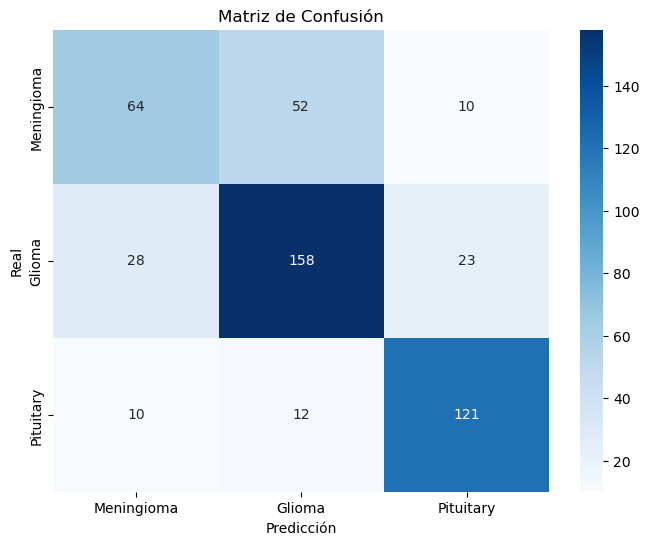

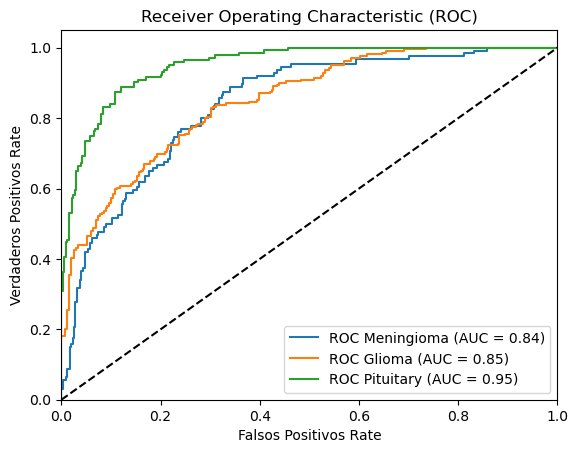

In [78]:
# --- EJECUCIÓN ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

# Input shape: (1, 64, 64)
modelo = RedNeuronalGeneral(input_shape=(1, 64, 64), num_classes=3)


train_model(modelo, train_loader, val_loader, test_loader, epochs=15, device=device, class_names=CLASS_NAMES)